<a href="https://colab.research.google.com/github/samaco634/deep-learning-basics/blob/main/%5B%EB%94%A5%EB%9F%B0%EB%8B%9D%EA%B8%B0%EC%B4%88_02_1%5D_%EA%BD%83_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EA%B5%AC%EA%B8%80%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 튜토리얼은 꽃 이미지를 분류하는 방법을 보여줍니다. `tf.keras.Sequential` 모델을 사용하여 이미지 분류자를 생성하고 `tf.keras.utils.image_dataset_from_directory`를 사용하여 데이터를 로드합니다. 다음 개념에 대한 실질적인 경험을 얻을 수 있을 겁니다.

- 디스크에서 데이터세트를 효율적으로 로드합니다.
- 데이터 증강 및 드롭아웃을 포함하여 과대적합을 식별하고 이를 완화하는 기술을 적용합니다.

이 튜토리얼은 기본적인 머신러닝 워크플로를 따릅니다.

1. 학습 데이터 모으기
2. 입력 파이프라인 빌드하기
3. 모델 빌드하기
4. 모델 훈련하기
5. 모델 테스트하기
6. 모델을 개선하고 프로세스 반복하기

## TensorFlow 및 기타 라이브러리 가져오기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 학습 데이터 모으기

In [ ]:
# 이미지를 구글에서 검색하여 다운로드하기 위한 util 설치
!pip install -q jmd_imagescraper

     |████████████████████████████████| 1.6 MB 15.4 MB/s 


In [ ]:
from pathlib import Path
root = Path().cwd()/"images"

from jmd_imagescraper.core import * # dont't worry, it's designed to work with import *

#                       폴더 이름 / 검색어 / 이미지개수
duckduckgo_search(root, "rose", "장미", max_results=500)
duckduckgo_search(root, "sunflower", "해바라기", max_results=500)
duckduckgo_search(root, "tulip", "튤립", max_results=500)

Duckduckgo search: 장미


Duckduckgo search: 해바라기


Duckduckgo search: 튤립


[PosixPath('/content/images/tulip/001_cdb6aba2.jpg'),
 PosixPath('/content/images/tulip/002_43a175dd.jpg'),
 PosixPath('/content/images/tulip/003_afc9ceeb.jpg'),
 PosixPath('/content/images/tulip/004_06cbb92f.jpg'),
 PosixPath('/content/images/tulip/005_ae9cbac1.jpg'),
 PosixPath('/content/images/tulip/006_5289d555.jpg'),
 PosixPath('/content/images/tulip/007_dac149ce.jpg'),
 PosixPath('/content/images/tulip/008_d32a0c17.jpg'),
 PosixPath('/content/images/tulip/009_46f6e429.jpg'),
 PosixPath('/content/images/tulip/010_ca39c47d.jpg'),
 PosixPath('/content/images/tulip/011_dd82037e.jpg'),
 PosixPath('/content/images/tulip/012_84fce299.jpg'),
 PosixPath('/content/images/tulip/013_af692c80.jpg'),
 PosixPath('/content/images/tulip/014_19b98e3d.jpg'),
 PosixPath('/content/images/tulip/015_67583b0a.jpg'),
 PosixPath('/content/images/tulip/016_587266c2.jpg'),
 PosixPath('/content/images/tulip/017_61eb4a19.jpg'),
 PosixPath('/content/images/tulip/018_5e442706.jpg'),
 PosixPath('/content/images/

다운로드 후, 데이터세트 사본을 사용할 수 있습니다. 총 이미지의 개수를 알아 봅시다.

In [ ]:
image_count = len(list(root.glob('*/*.jpg')))
print(image_count)

1500


장미의 경우는 다음과 같습니다.

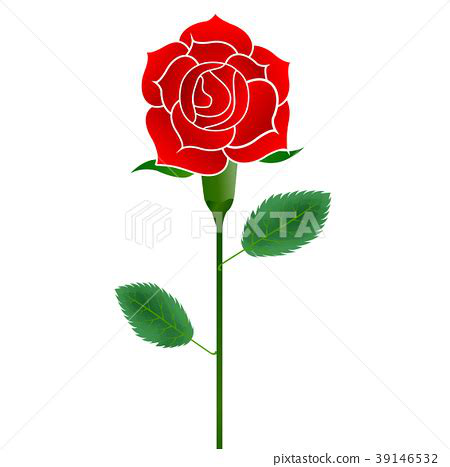

In [ ]:
roses = list(root.glob('rose/*'))
PIL.Image.open(str(roses[0]))

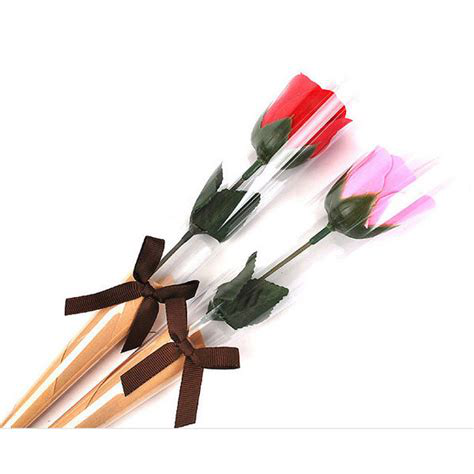

In [ ]:
PIL.Image.open(str(roses[1]))

튤립 그림도 확인해봅시다.

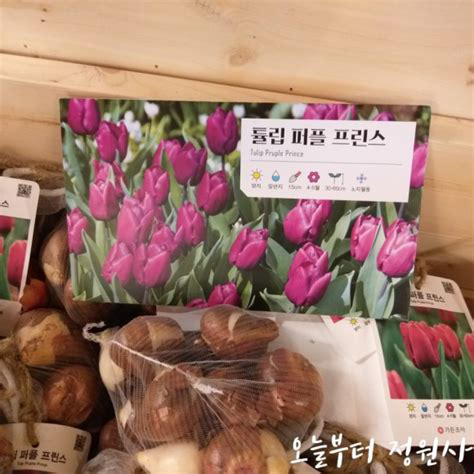

In [ ]:
tulips = list(root.glob('tulip/*'))
PIL.Image.open(str(tulips[0]))

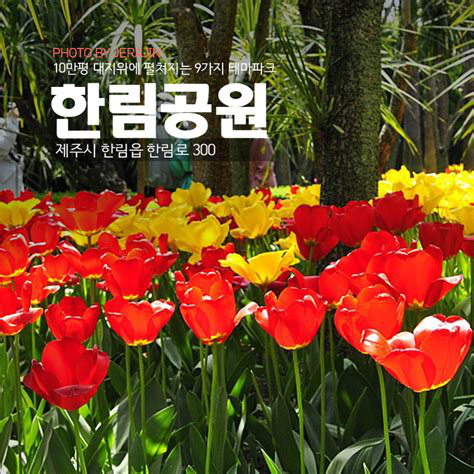

In [ ]:
PIL.Image.open(str(tulips[1]))

# Keras 유틸리티를 사용하여 데이터 로드하기

유용한 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 디스크에서 이러한 이미지를 로드해 보겠습니다. 이러면 몇 줄의 코드로 디스크의 이미지 디렉터리에서 `tf.data.Dataset`로 이동하게 됩니다. 

## 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.


이러한 데이터세트의 class_names 속성에서 클래스 이름을 찾을 수 있습니다.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['rose', 'sunflower', 'tulip']


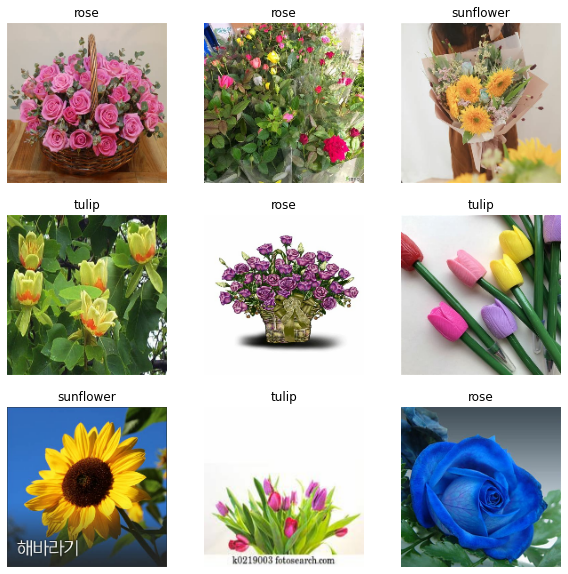

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 model.fit(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch는 (32, 180, 180, 3) 형상의 텐서이며, 180x180x3 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). label_batch는 형상 (32,)의 텐서이며 32개 이미지에 해당하는 레이블입니다.

참고: 이들 텐서 중 하나에서 .numpy()를 호출하여 numpy.ndarray로 변환할 수 있습니다.

### 데이터 표준화하기
RGB 채널 값은 [0, 255] 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 tf.keras.layers.experimental.preprocessing.Rescaling 레이어를 사용하여 [0, 1] 범위에 있도록 값을 표준화합니다.

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.

참고: 픽셀 값을 [-1,1]으로 조정하려면 대신 Rescaling(1./127.5, offset=-1)를 작성할 수 있습니다.

참고: 이전에 tf.keras.preprocessing.image_dataset_from_directory의 image_size 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 tf.keras.layers.experimental.preprocessing.Resizing 레이어를 대신 사용할 수 있습니다.

### 성능을 위한 데이터세트 구성하기
버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

.cache()는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 훈련하기
완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 

# 모델 만들기

[순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 높은 정확도를 위해 조정되지 않았습니다. 이 튜토리얼의 목표는 표준 접근 방식을 보여주는 것입니다.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일하기

이 튜토리얼에서는 `tf.keras.optimizers.Adam` 옵티마이저와 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달합니다.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## 모델 요약

모델의 `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 64800)             0

## 모델 훈련하기

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
38/38 [==============================] - 15s 130ms/step - loss: 1.7943 - accuracy: 0.4275 - val_loss: 0.8163 - val_accuracy: 0.6100
Epoch 2/10
38/38 [==============================] - 1s 28ms/step - loss: 0.7470 - accuracy: 0.6900 - val_loss: 0.6214 - val_accuracy: 0.7600
Epoch 3/10
38/38 [==============================] - 1s 28ms/step - loss: 0.5622 - accuracy: 0.7775 - val_loss: 0.5862 - val_accuracy: 0.7200
Epoch 4/10
38/38 [==============================] - 1s 31ms/step - loss: 0.3712 - accuracy: 0.8683 - val_loss: 0.5491 - val_accuracy: 0.7467
Epoch 5/10
38/38 [==============================] - 1s 21ms/step - loss: 0.2661 - accuracy: 0.9183 - val_loss: 0.6519 - val_accuracy: 0.7367
Epoch 6/10
38/38 [==============================] - 1s 22ms/step - loss: 0.2348 - accuracy: 0.9250 - val_loss: 0.7380 - val_accuracy: 0.7400
Epoch 7/10
38/38 [==============================] - 1s 21ms/step - loss: 0.1345 - accuracy: 0.9617 - val_loss: 0.8958 - val_accuracy: 0.7200
Epoch 8/10


## 훈련 결과 시각화하기

훈련 및 검증 세트에 대한 손실 및 정확도 플롯을 생성합니다.

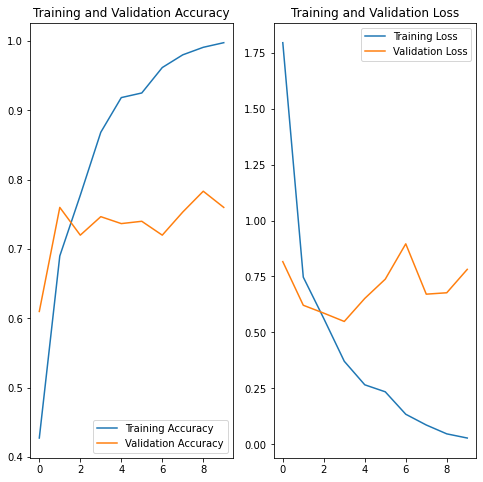

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯은 훈련 정확도와 검증 정확도가 큰 차이로 떨어져 있으며 모델은 검증 세트에서 약 80%의 정확도만을 달성했음을 보여줍니다.

무엇이 잘못되었는지 살펴보고 모델의 전반적인 성능을 향상시키도록 하겠습니다.

1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


1/1 [==============================] - 0s 17ms/step


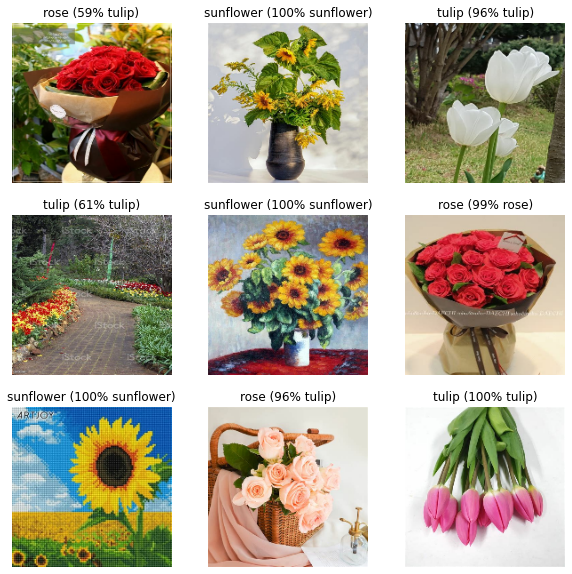

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predictions = model.predict(tf.expand_dims(images[i], 0))
    score = tf.nn.softmax(predictions[0])

    plt.title("{} ({:2.0f}% {})".format(class_names[labels[i]],
                                100*np.max(score),
                                class_names[np.argmax(score)]))
    plt.axis("off")

## 새로운 데이터로 예측하기

마지막으로, 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류해 보겠습니다.

In [ ]:
flower_url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhMTExMVFhUXGRgXGBUYFxUYGRYYHhcYGBYbGRgdHSggGBolHRcVITEhJSkrLy4uGB8zODMsNygtLisBCgoKDg0OGhAQGy0lICUvLS8tLS0tLS0tLS0tLS0tLS0tLS0tLS0tMC0tLS0uLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAOkA2QMBIgACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABAUDBgcCAQj/xAA8EAABAwIDBQUGBQQCAgMAAAABAAIRAyEEEjEFQVFhcQYTIoGRMqGxweHwB0JSYtEUI3LxgrIVNCSDkv/EABsBAQACAwEBAAAAAAAAAAAAAAADBQECBAYH/8QAMxEAAgECBAMGBQQCAwAAAAAAAAECAxEEITFBElHwBRNhcYGxIjKRodFCweHxFBUGIyT/2gAMAwEAAhEDEQA/AO4oiIAiIgCIiAIiIAiIgCIsVaqGiStZzjCLlJ2S1MpXyRlRRqOJa6w14KRK1pVYVY8UGmuaDTTsz6iKvx2LLTlbrvUeKxVPDU3UqaeGrfJGYRcnZFgixUqgcARvWVTRkpJSWjNbWCIi2AREQBERAEREAREQBERAEREAREQBEWCpiWtME+4qOpVhTjxTaS5t29zKTehnVbi8SZc0ab/RTe+bxVD3/iJO8ql7cxnd0oRhK3E3e3JL+V5k9CF27onYLFxZ2nw+iy7Tfdo6lVpdBXzEOKof9nUWElh5Z6We6SadvHT0z8LT90uPiR8rVoNlZ4DGZ2Gfab7+aoHO4rJh6pBMGJF/vyXN2f2jLC1nP9Lya9n5p/a5JUpKUbF5jMaBZpvvPBVFWuA4A63k/D1SrUABdwVOasnqZnpYfNZxmOq4qfFP0Wy/nxftklKiorI2/ZTvBrZK+0NzBJ46BVmHqnIBu4KFiq2c5G6fmPyXcu2akMPClSysld7+Nr3SW12m/BEaoJzbZsdLGsJDQ6Sd4FvVTVreBd/cYBxWyL0HY+NqYylOclpK2V9LLd3v5nNWgoNJBERWxCEREAREQBERAEREAREQBERAFXbUF2+a8OxTmuImY4gfKF4rYovEFum+fkvOdodpYevh50k2pX0aeqayurr6ux006UoyT2K+vXIdyhYv6gEX9F7xLbgqG8Lx0pPiaO5JMkudb4LJUqKEKto++ax08VNjqLLX4rOxtwmSo9Gu+Ci4iovlWrDSeAPyWVA3UTztPF2DAdbJRHiI3NACoMRjj3jQLmQVd993bL+0fF/C6Z0nCKS3JHGysT62I0pt1OvIKVTpBoAH++ZVfsinY1Hau06fVTi/6/wuadl8JFJWdkeKtUtuDBF1LbiSGZi48dVU1X5iB+rT/EXJXqsS4ho6fz7lvGUo6Prc1cFubHsaoSX3tAPmrhU+za9NjIm5MmxMcBPT5qbQxrHnK3Xovc9lVqNLD06Mqic3txJu7bdrX2vYra0W5NpZEtERXJAEREAREQBERAEREARFgr12s9orSdSNOPFNpJbvJGUm8kQdpZc0g33j4FV/erLXgHwac938qBXcvnnaGIc68p2SbezuvR+O7yz2TulZUo2jYzVhNwoFd9lm72NVFxThEjT4KvWcrk8UYDUv96KHSqEk3sRE/uBg+9Ya2Ih44Ex6rUttbWe19RgNs2ZpaQZsZ465r9AVZYfCSqvhiTZI2Wpt+nmax7hLiQ194JBiHfpPPRYtqbfYxopNu4glx3MbJk8zZaBXxWeSSdLXJjSLE3Gtumq8PfI1EyW24fKP5VtHsuCaefl49bftka8SRsuztsMpzWc0vd+VugHMn3RyKscDtB2IOsue4A/tHwEeK0rRc5FjuP8Ar3Ae/wA5ez9pGm4OYdCIuYsQSBrY6G3FTVsDFpyjr1ZdamYzzudeOJAsNGwAOcWHkEq1LQTA1ceA4dStY2X2koG7yQZJDcryS6T+2JjLv+t/g6Tn/wByoMrdWsP/AGf/AAvNVaLo/Oree/lzMWSJVBv5ogmwHBv1/hZMLdxjQWJ+Sh4jaQJyU/E47xoPPerHCtFNobv38zvUMk4q7Wpq8kZn1Mo4D79VJ2FQqPqd6TDGzA/UYj0CwPcN4Cz7MxEVGtzRwF/IEaBd3ZUqf+VDjV81bOyvs3flrb+nz1b8DsbKiIvozTWpVhERYAREQBERAEREAUTG4bOJGo96lrHUeGiSYUGJo06tNxq/L7eN9rczaLad0a7iKRuBIPoQq/vCLFbBjcQx2gvx0/2qfFNDtLFfPMbRpUqjjCakua6tfna6+6VnSk2s1Yr8Q+3zVdUrkSJvu++CsMVSsqTFsc2CASB7v5C1oRTyOqKVij25jn0zAy5XXIINjvggaaHXSdFqOMqkkm5JM68b+WsfFXXap5NURN2iRbdJPPSBB4c1r9SdNSOG8iy9RgqajTjLdms2fGtvvEjnz+/MrM4ADd57tfRfHVQGSR9B/oBVxxDnTcR9/wAldqjKbyOeU0s2WQptLbnT4X3TbUeq8vw+oabW9+m7mFDYDDZdJEjT0PvPqpOHfl1GpknjcX+KShKO5iM0zGKrmxBg2G+fhwW0dm8b3kU3Pe4n2Rmc6LSbTHK8LXqlG3SN2uggaixnQL3sjE5KgdA52n8t4aTcnqNFBiIKrTdtdjopyszsOzsI2mIYJf8Amcbx5/IKe1vmeKi4TH0SxpDxBEgGx8wVKbVB9kE8zp9V4mpxNtyT9TErvUx4mvlEquw7qj3GCQNSrY0Wn2gD1XsNA0EdFiM0la2Zi9j7g6lU1KdNmYAxLp0A1t048Vt61zs0Hd5VJMiB5XMfP0Wxr3X/AB+mo4RSv8zfllll1rcrcS/jsERFdnOEREAREQBERAYqs5Tl13KgxDnT4iZ5rZFgr0GuFwJVR2r2bPGRXBOzWz+V/TR+OZNSqqGqNdy8z6rxUc0amVixjy17muEEHSbRujSVgq4nK0nL6fReEqQlCTg1mnbq/wCCyjnmZKtUR9FT4+mHGWVTTPLKR6Fe/wDyDjuk8foouIHeWLJ6a+UqSnTcHn+z9yaMbHPtuNe2q4PcZ3brTaIJEHlxVW8TzPD019Fs3avCZDmGnEyHaCJuJOo6ALVqrAN/8R8l67CTU6UWjWZ9xAEEC43/AC98+iiEgCfvfuX0O1EyPMWvv9V4qfHQSef35KwpLhdmcdVXRip1Z9VcYQZmG4MX68h10VXhsOSQI1PyVyxmRuWRJ9Bpbr8IWMU1puaUk7kdwc4GLj6aR0v5ngorKhaQeB3a+XD6BSahAEkGSTfja8ec+gWOgM790zedPP73DgoY6O+h1x1Osdj9o0qmHYAcrmgNIIiTxB/MFsMfu+AVJ2X2aKVIB2WXQTEkExqJFumiuxh2n6Ej4LwuKcHVlw3tc3la54qVWtEkqNRxhqvDKTSSTGnvJ0AUpzMpsPP7us2ywGVhUaYB8L27iOMbiDeeqkwcKM6sY1XaLeb6089tdjSbtFtK7NlwGEFJgaLnUnid5UpEX0uFNU4qEVZLKxUNtu7CIi2MBERAEREAREQGOpUDRJMBVlfHE6HKPQqXtKoG03OLQ4NguBE+GRmMchJ8lhOBo1GhzQL6ObH+iqvtCjiqy4KE1He2ab9Vml4JZ6PIlpyhF/EVlWk12tzxkyq7FMy2AzcQrF7ADDX5hxygf7WArwldcMnez8U7p+qyfmWMGUjMOGg5wZm1jp1UeqW/uHQrYK9JxabwVX/0AF3meW7zWI1F+onjJGpbbxIFN9NgLqjhYuvl6Ddaed1z/E2EHXTkOmnouxPxLZysYCeQgeq1TtF2Xe4l7WNEmYDha2nr8VednYyFN8M1a+d2/Q2lG5z5zsoFvf8AVeqLr9D87X36aLLjMG9hAc0iePyv0WMwBa0/wV6K6aViCUcyc17habSDrv1BmeOW/BfH1ABznfHM9dSoNFzjvsCRPrb7+SBx0F+Hv14a+4LTuzWxlc+Ta32fdy+q2TsXsbv6uZw8LYJuRGhb8D6Kj2bgX1SWta420G4THxcusdk9j/01Mh2XM6NNw3DmqztTFqjScYv4n0/sSpWVy9aBGi9hYs0L46oRu9F47huYsZqgUKtjGN1dfhCkCt6Kvx2DY82uTuabzpaFLCKbs/sYXibrsoEU25iTIBB5ESOanqLgKRbSY10FzWgGNJAhSl9Po01TpxgtEkvoU8ndthERSmAiIgCIiAIiIDw9oIINwbELndTHVcFXqUWnwg2aZh7TdvQxaRvC6OtH/EvZpNNmJYL0/C+BfKbh3kf+y4sdScoccMpR9t/z6Az7M2th6xylwomAA03BO85zboLab1KIDZgzfXSVzXA48yHAjM2+k6aGDb6+S2rZu3XPa7vQ0ZRObSbxccei8ljqS4E4QimtWsr7LLTfZctjqoVXJ2b68y9Y+ZKg4zxbp4N/ngvI2kxzJa4G0kDd1GoWHZ2Ma95F7AkWgKocJrNrQ74c0SqFHKItO87h9EazMbeu9eq9QNmTbevGzsSHuIHBRKMndmbu1yu27sZlcAOA09qASBuA9Vp22exMGn3PiaYmdS7eem/yXS6jdVFHhtuXVh8bWoWUXptsZUsjmWH7D1zTzWE/kdqTJAGluvNbXgOw9Bg8cvsOQBtJHmFtDTLQQvYupK/amJq5OVvLIcXIrdk7GpUA8Ux7Tsxm8GNx1iZPmVYPYCvFV8RPL+FlB3HVcEpSk+KTuzDbItSi78pg8Ddp8lAr7SdTs+keoNirkhQcZWLfapl7T+kSR1C3pO7ta/uFI1zae1alQFoJY3lqepW0/h/sw5O+qODrkMb+mNS7nwHC++1fT2fSqnwBwP6SHD3ELY+y+DdSLmwcp5QJGnzXoeyZw7+Ee7dvLR21v/O5FiZLu2o5GyIiL2ZVBERAEREAREQBERAF4e0EEESDYg717RAcd7bdnjg6wfTH9moTlG5rt7DyjTl0VdTqEjTX5ffvXX+0Oym4qg+i7eJa79Lx7J9fdK4XUFWg9zHtMtJDmncRa3Aqix2GUZXjo/fdGDcWV6dFmUgPeTLoiAdzZ0t8ZU7Ye1y/vB3TMsCHSZaZsI0JN+C0V+KdAg2Omnmtjw2Op4bDUw4g1H+PLI1d7OY/lERrzVHVounnH4pyyW+qzstFZacss8jto1XJ2btBdK71ZabTe5xE6aCFa7IwuVuY6n4Kl7M4tuJ7yTmDHgDmMuoG4E5vKFstWsGNJNgFWVk4S7t7f2dveKcfh0Plc6qq2liIho9pZxtJpYajvCBuOpvA9VUbGq99Xc47pIUcKbvKbWSNoK2bL/DNyNa3kJ9Fmc3gvL9FEwtYibyPgOSgWd2a5tNmHauIhjg6xgwdx6e5Sqby9gcDBjVU/aLGMe0Mb4rySNB9VP2I492AdymnTtSUt7mzyjc809pOyzUblIJaY0sYnkCsmx9vCnig17gKbm5SdwdqCT7vNR6zwc0xqRCrcC6k1z87bTGbUAbpGsrtwdR0avfQjms7deBpVUFG0tGbXtDtpTHhoNNQ/qMhv8n3dVVUcfi8U/K2oZ1IaSxjRzIuR6qh7vPV7ukJzOhsb50ngP4XTtj7Mbh6YY251c7e538cAvS4eeIx0ryk1Bcrr0/N/RXKcw7P2K2nBc9738S5wHkAdOsq3RFeU6UaatFWAREW4CIiAIiIAiIgCIiALmv4n7MyPZiWiWv8FQfuA8J8wCP+IXSlW9oNmjE4erRP5m+E8HC7T6gKHEUu9puP08wcJDmgmDY6tNiOYm0/FRMZT0Mgz4pGkXA89ZHRTauGg5XC99bEEWI8iovd5TBnKTcCLcwZ1+K89CSNSx7N9oRhQ6WFwJDgBAk3BzGJNrhY9udq6leuCC9tFhBbT9nMRcZiOJA6BVWIpEHrcRoRujloE7u1z7/VO4pd53rV3p9ktPQ372fDw3yOmUmh7W8HtzAe/wCYWfDYUU3Zm2j4LR+yu1DTql9R5NOnTIMk+FpqU2iJ4ToOChbb7X1MR3rWeCkDDQPaePFdx5wDAjzVT/ra7qcC+W129v760zLB4yLjxW9Doe0NoZz3VMmYzO5DcORPyUSjj3Me1jgZddros4RNxuMKo/DuuKznMuaxIJkzLYgHy3rpm18DRZT710NFJt3R+WIsN7tAOsKWn2VUnGooL5ba5cTazz8FbXK2WpIsTTUY8nf0KursLDOpU6r5pgh2d4cBlm4Jm0AiNPzKqwm1qBJYx5IFmuc3LnHEcPOFS7U2rUxLgDLabfYpA2A4u/U43v6KM2mACTYD7txKmxyoVYRpwirq2a3drfTzzepwrEzUm1pnqTsbtXx1MhBZIBkTJiDHO3uVU/EcfIfepXivUE8OA3/7WGhSqVqjKVMS95ytHDiSeA16BaUqC+SHgvMiq1XN9ZG+/htgJFTEOG802dNXkeZAn9pW+KDsjANw9GnRZoxsTxOrieZJJ81OXr8PRVKmoLp7moREUwCIiAIiIAiIgCIiAIiIAiIgOX9vdkBmIzR4K3iBjSoPaHKbO5yVpdbDPBh0Ecd/xXcO0Gym4qg+k6xN2u/S8eyfvcSuRVA5rnUatqjDlc0jXmDvm3uN1QY/DypT7yOj+zMMq6NEDwaz7JJ9k7xpad3PqsNXCONwIHDl929VauwwO4DnoR71NOHc4CTJ3njzHUR71w99uYsVmG2Q4YLF13ECQKTW7z42OceggDzWqYej/bPEuiPIGfl5rb+0FWMPk3B0jlI8UcjYqn2LRzNIOgdJ9F1063/XxGdjPsFzqNSlWbOZjg6xiQCJHQi3mupdvsbnyUGmwh7+Z/IPifRaPhcOAC59mtGY8mjUfHzPNRaPaN9XE53iQ91xwBs0DoICi/yKkqNSMPD2d/2X1MIuKeGgX6k8Oqh47FNFybD2W2nrrr8NOubbW0GNOUOsNw/M4c59ke89AtcrVHVLwOv83hclCi5Zy9euuRs+RkqY0EyAfOB8zK6P+GGxSGHF1Bd4LaY/SyfEeriPQc1y5lIuIa25JAHMkwPev0ThMOKdNlNogNaGgcABAV5gaEVJy5GqM6IitjYIiIAiIgCIiAIiIAiIgCIiAIiIAtN7e9lziGivRH99mo07xo3f5Dd6cFuSLScFOPDLQHENk1xUljgc4m17jfbcQfvjMotg926DOk2kHz3feq2jtv2ONR39Vhh/dF309O85t4P+PXXU8Li21fC8HO2Z3G3tA8HC8jrzXl8ZhJUJX266a/AKztczwMI/VB5WKjdkqYPeTxED1+/qrDtU/Nh2k6h4BPGxv5qT+FWy/wCoq1g4+BmRzhvM54HQwZ5LfDwlVoOEdb/uv7DRYdqcJ3OADne1We1rRwaJe49DlA8+a0Wn4b6HdyW+/i7i5r0KI0psLyBxe6B6Cn7+a0INJPM/dl39xCl8Edt+b59aLJZGGZ6tcuILtNIEAwNBpZeKlUnkOC2LYnYvEV/Eab2N4uaWk9M0W5rctl/h1SaQat/2kzPyHvUSpPi4IwbflZfV2X0u/Axa5qn4edn34jENquBFKkQ4uuMzxdjQesE8hzXZ1hw2HZTaGMaGtGgAgLMrmjT7uNja1giIpQEREAREQBERAEREAREQBERAEREAREQBaz2l7J08Se9ZFOuLh40cRpnjfwcLjnotmRaThGceGSyBw3tJRcylUp1QW1GPbLN1xAI/abwrH8Jsa2h/W1HmGNpsef8AiXaf/qPNX/4t4CaLKzW3nI8gbvaaTyEOH/Jcs2ficrw0k5CQXNH58plrSN4mFTQg8LOSWdrteVvz7GWdI2B2Wdj3uxuMzBtQ5mUwYLm6CTqGQABFyBNt+/7P2XQoCKNJjP8AFoBPU6nzWXZ73OpUy9oa4tBLRo0xopKuKcFFZfyYCIikAREQBERAEREAREQBERAEREAREQBERAEREAREQBERAUfbWjnwOIbE+D4EH5LjHYfC5to4ZpE/3AY/xBf8l2ntl/6WI/w+YXKfw2oj/wAjR5Cob8e7cFXV3/6Yrml7sM7giIrEBERAEREAREQBERAEREAREQBERAEREAREQBERAEREAREQFF22P/wcR/iP+wXNvw5wbamObmE5KbniCQQ4FoBkdT6ro/bv/wBDEf4j/s1aD+F//vf/AFP+LFV11fGwT5L3kZ2OuoiK0MBERAEREAREQBERAEREAREQH//Z'
flower_path = tf.keras.utils.get_file('flower.jpg', origin=flower_url)
print(flower_path)
#flower_path = "/content/images/sunflower/496_b0dede7e.jpg"

/root/.keras/datasets/flower.jpg


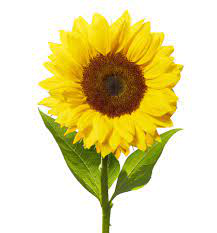

In [ ]:
PIL.Image.open(flower_path)

In [ ]:
img = tf.keras.utils.load_img(
    flower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

print(img_array.shape)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

(1, 180, 180, 3)
1/1 [==============================] - 0s 18ms/step
[[-4.6651163  4.3247423 -3.3029575]]
This image most likely belongs to sunflower with a 99.94 percent confidence.
